In [ ]:
import sys
import pypsa
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

idx = pd.IndexSlice

In [13]:
bmus = pd.read_csv(Path.cwd().parent / 'data' / 'preprocessed' / 'prepared_bmus.csv', index_col=0)
plants = bmus.loc[bmus.carrier.str.contains('wind')].index

In [25]:
path = Path.cwd().parent / 'data' / 'base'
day_range = pd.date_range(start='2024-03-01', end='2024-03-31', freq='D')

bids = []

for day in day_range:
    bids.append(pd.read_csv(
        path / day.strftime('%Y-%m-%d') / 'bids.csv',
        index_col=[0,1], 
        parse_dates=True,
        ))

bids = pd.concat(bids)
bids = bids[plants.intersection(bids.columns)]
bids = bids.loc[idx[:,'vol'], :]
bids.index = bids.index.get_level_values(0)

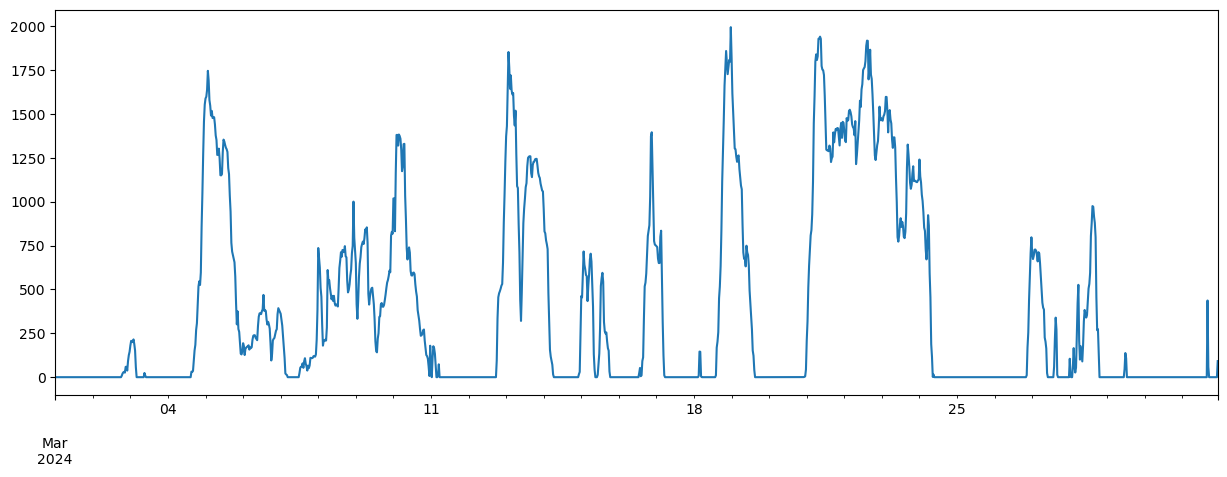

In [26]:
fig, ax = plt.subplots(figsize=(15, 5))

bids.replace(np.nan, 0).sum(axis=1).plot(ax=ax)

plt.show()

In [50]:
nodaln = pypsa.Network(
    Path.cwd().parent / 'results' / '2024-03-22' / 'network_s_nodal_solved.nc'
)
natn = pypsa.Network(
    Path.cwd().parent / 'results' / '2024-03-22' / 'network_s_national_solved.nc'
)

INFO:pypsa.io:Imported network network_s_nodal_solved.nc has buses, carriers, generators, lines, links, loads, storage_units
INFO:pypsa.io:Imported network network_s_national_solved.nc has buses, carriers, generators, links, loads, storage_units


In [60]:
nodaln.statistics()

Optimal Capacity  Installed Capacity  \
Generator   biomass               2028.00000          2028.00000   
            fossil               25331.00000         25331.00000   
            local_market         20640.00000         20640.00000   
            nuclear               4347.00000          4347.00000   
            offwind              11547.48333         11547.48333   
            onwind                6354.51667          6354.51667   
            solar                   53.50000            53.50000   
Line        AC                  873740.82411        873740.82411   
Link        DC                    3400.00000          3400.00000   
            interconnector       10320.00000         10320.00000   
Load        Belgium                  0.00000             0.00000   
            Denmark                  0.00000             0.00000   
            France                   0.00000             0.00000   
            Netherlands              0.00000             0.00000   
            Norway                   0.00000             0.00000   
            electricity              0.00000             0.00000   
StorageUnit PHS                    740.00000           740.00000   
            battery                631.87083           631.87083   
            cascade                284.00000           284.00000   
            hydro                  567.00000           567.00000   

                                  Supply    Withdrawal  Energy Balance  \
Generator   biomass         7.196440e+04  0.000000e+00    7.196440e+04   
            fossil          1.593587e+05  0.000000e+00    1.593587e+05   
            local_market    7.549470e+05  0.000000e+00    7.549470e+05   
            nuclear         2.084920e+05  0.000000e+00    2.084920e+05   
            offwind         4.298196e+05  0.000000e+00    4.298196e+05   
            onwind          2.711675e+05  0.000000e+00    2.711675e+05   
            solar           4.555000e+02  0.000000e+00    4.555000e+02   
Line        AC              1.048172e+07  1.048172e+07    0.000000e+00   
Link        DC              1.604441e+05  1.604441e+05    0.000000e+00   
            interconnector  3.006686e+05  3.032645e+05   -2.595870e+03   
Load        Belgium         0.000000e+00  4.915200e+04   -4.915200e+04   
            Denmark         0.000000e+00  6.720000e+04   -6.720000e+04   
            France          0.000000e+00  2.588640e+05   -2.588640e+05   
            Netherlands     0.000000e+00  5.294400e+04   -5.294400e+04   
            Norway          0.000000e+00  6.720000e+04   -6.720000e+04   
            electricity     0.000000e+00  1.437555e+06   -1.437555e+06   
StorageUnit PHS             2.277228e+04  1.103244e+04    1.173985e+04   
            battery         1.141113e+04  9.540814e+03    1.870315e+03   
            cascade         1.019578e+04  0.000000e+00    1.019578e+04   
            hydro           1.550040e+04  0.000000e+00    1.550040e+04   

                            Transmission  Capacity Factor   Curtailment  \
Generator   biomass              0.00000         0.739279   14171.10279   
            fossil               0.00000         0.131064  980865.27976   
            local_market         0.00000         0.762019  235773.00000   
            nuclear              0.00000         0.999214       0.00000   
            offwind              0.00000         0.775457   32048.13766   
            onwind               0.00000         0.889025    8478.80562   
            solar                0.00000         0.177375       0.00000   
Line        AC              713942.06602         0.249924       0.00000   
Link        DC               50755.88601         0.983113       0.00000   
            interconnector       0.00000         0.612653       0.00000   
Load        Belgium              0.00000              NaN       0.00000   
            Denmark              0.00000              NaN       0.00000   
            France               0.00000              NaN       0.000

In [82]:
supplies = pd.concat((
    nodaln
    .statistics()
    .loc[idx[['Generator', 'StorageUnit', 'Link'], :], 'Supply']
    .rename('nodal'),
    natn
    .statistics()
    .loc[idx[['Generator', 'StorageUnit', 'Link'], :], 'Supply']
    .rename('national'),
    ), axis=1).drop(index=('Link', 'DC')).groupby(level=1).sum().mul(1e-3)

withdraws = pd.concat((
    nodaln
    .statistics()
    .loc[idx[['Generator', 'StorageUnit', 'Link'], :], 'Withdrawal']
    .rename('nodal'),
    natn
    .statistics()
    .loc[idx[['Generator', 'StorageUnit', 'Link'], :], 'Withdrawal']
    .rename('national'),
    ), axis=1).drop(index=('Link', 'DC')).groupby(level=1).sum().mul(-1e-3)

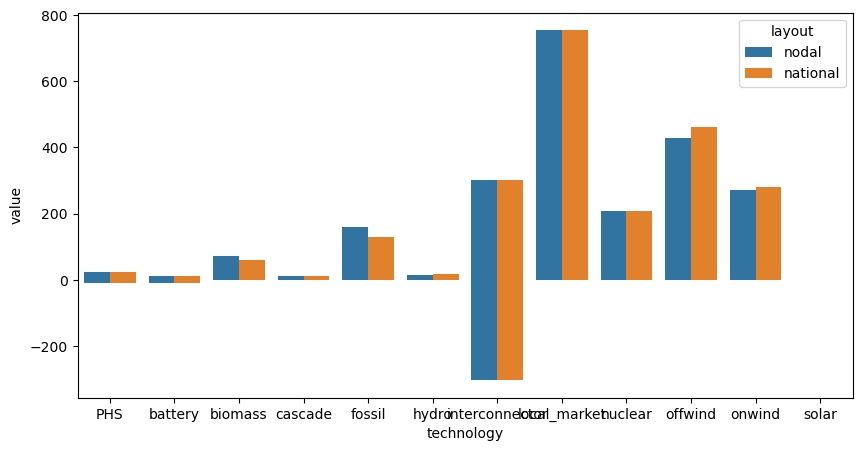

In [87]:
import seaborn as sns

fig, ax = plt.subplots(1, 1, figsize=(10, 5))

s = supplies.stack().reset_index().rename(
    columns={
        'level_0': 'technology',
        'level_1': 'layout',
        0: 'value',
        }
)
w = withdraws.stack().reset_index().rename(
    columns={
        'level_0': 'technology',
        'level_1': 'layout',
        0: 'value',
        }
)

sns.barplot(
    data=s,
    x='technology',
    y='value',
    hue='layout',
    ax=ax,
    )

sns.barplot(
    data=w,
    x='technology',
    y='value',
    hue='layout',
    ax=ax,
    legend=False,
    )

# ax.set_yscale('symlog')
plt.show()

In [ ]:
withdraws = withdraws.loc[withdraws.index.get_level_values(0).str.contains('wind'), :]

,nodal,national
PHS,22772.28394,22505.83083
battery,11411.12940,11053.17222
biomass,71964.39721,59184.48083
cascade,10195.78333,10195.78333
fossil,159358.72024,130795.02250
hydro,15500.40000,16268.40000
interconnector,300668.64500,300668.64500
local_market,754947.00000,754947.00000
nuclear,208492.00000,208492.00000
offwind,429819.61234,461867.75000


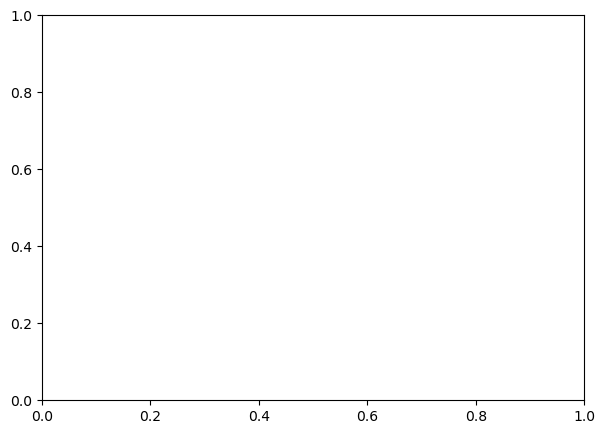

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(7, 5))



plt.show()

In [51]:
natn.buses.loc[natn.buses.country != 'GB']

,v_nom,type,x,y,carrier,unit,v_mag_pu_set,v_mag_pu_min,v_mag_pu_max,control,generator,sub_network,country
Bus,,,,,,,,,,,,,
Belgium,380.0,,3.12,51.23,electricity,,1.0,0.0,inf,Slack,belgium_local_market,,Belgium
Denmark,380.0,,8.40,55.43,electricity,,1.0,0.0,inf,Slack,denmark_local_market,,Denmark
France,380.0,,-1.71,49.64,electricity,,1.0,0.0,inf,Slack,france_local_market,,France
Netherlands,380.0,,3.56,51.53,electricity,,1.0,0.0,inf,Slack,netherlands_local_market,,Netherlands
Norway,380.0,,5.50,59.02,electricity,,1.0,0.0,inf,Slack,norway_local_market,,Norway


In [40]:
ns.buses.loc[ns.buses.country != 'GB']

,v_nom,type,x,y,carrier,unit,v_mag_pu_set,v_mag_pu_min,v_mag_pu_max,control,generator,sub_network,tags,under_construction,country,symbol,substation_lv,substation_off
Bus,,,,,,,,,,,,,,,,,,
Netherlands,1.0,,3.56,51.53,electricity,,1.0,0.0,inf,PQ,,,,NaN,Netherlands,,NaN,NaN
France,1.0,,-1.71,49.64,electricity,,1.0,0.0,inf,PQ,,,,NaN,France,,NaN,NaN
Belgium,1.0,,3.12,51.23,electricity,,1.0,0.0,inf,PQ,,,,NaN,Belgium,,NaN,NaN
Denmark,1.0,,8.40,55.43,electricity,,1.0,0.0,inf,PQ,,,,NaN,Denmark,,NaN,NaN
Norway,1.0,,5.50,59.02,electricity,,1.0,0.0,inf,PQ,,,,NaN,Norway,,NaN,NaN


In [37]:
ns.links

,bus0,bus1,type,carrier,efficiency,active,build_year,lifetime,p_nom,p_nom_mod,...,ramp_limit_up,ramp_limit_down,ramp_limit_start_up,ramp_limit_shut_down,p_nom_opt,tags,under_construction,geometry,underground,underwater_fraction
Link,,,,,,,,,,,,,,,,,,,,,
8009,5896,5939,,DC,1.00,True,0,inf,2200.0,0.0,...,NaN,NaN,1.0,1.0,0.0,"""MW""=>""None"", ""TSO""=>""None"", ""oid""=>""70191"", ""...",0.0,"LINESTRING(-3.18595885129092 53.213699479605,-...",0.0,0.979689
8708,6443,6448,,DC,1.00,True,0,inf,1200.0,0.0,...,NaN,NaN,1.0,1.0,0.0,"""MW""=>""None"", ""TSO""=>""None"", ""oid""=>""115391"", ...",0.0,"LINESTRING(-3.45338156475634 58.4908032474467,...",0.0,0.583200
IFA1,France,4977,,interconnector,0.99,True,0,inf,2000.0,0.0,...,NaN,NaN,1.0,1.0,0.0,,NaN,,NaN,NaN
IFA2,France,4955,,interconnector,0.99,True,0,inf,2116.0,0.0,...,NaN,NaN,1.0,1.0,0.0,,NaN,,NaN,NaN
ElecLink,France,5269,,interconnector,0.99,True,0,inf,1277.0,0.0,...,NaN,NaN,1.0,1.0,0.0,,NaN,,NaN,NaN
